In [1]:
# !pip install pmdarima

In [2]:
!pip install prophet

In [3]:
import pandas as pd
from datetime import datetime
from dateutil import parser
import math

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy.fft import fft, ifft
from matplotlib.ticker import AutoMinorLocator

from pmdarima.arima import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error


import os
os.getcwd()

'C:\\Users\\Ran Liao\\Desktop\\CU\\FALL2022\\Forecasting\\Forecast_Project2'

In [4]:
import warnings
# warnings.simplefilter("ignore", ValueWarning)
warnings.simplefilter("ignore", UserWarning)

# Data Loading

In [5]:
df1 = pd.read_excel('data/online_retail_II.xlsx',sheet_name='Year 2009-2010')
## Filtering Dec 2010 data from df1 since there is an overlap in df2
df1 = df1.loc[df1['InvoiceDate'] <= pd.to_datetime('2010-11-30')]

df2 = pd.read_excel('data/online_retail_II.xlsx', sheet_name='Year 2010-2011')

df = pd.concat([df1,df2], axis=0)

In [6]:
df.to_csv('data/full_data.csv')

In [7]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4272
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235125
Country             0
dtype: int64

In [8]:
# External Datasets
unemployment = pd.read_csv('data/unemployment.csv')
earnings = pd.read_csv("data/earning.csv")
retail_spending = pd.read_excel('data/retail_spending.xlsx',sheet_name='ValNSAT', header=4)

# EDA & Data Processing

In [9]:
df['Country'].value_counts(normalize=True).sort_values(ascending=False)[:4]

United Kingdom    0.918804
EIRE              0.016969
Germany           0.016555
France            0.013476
Name: Country, dtype: float64

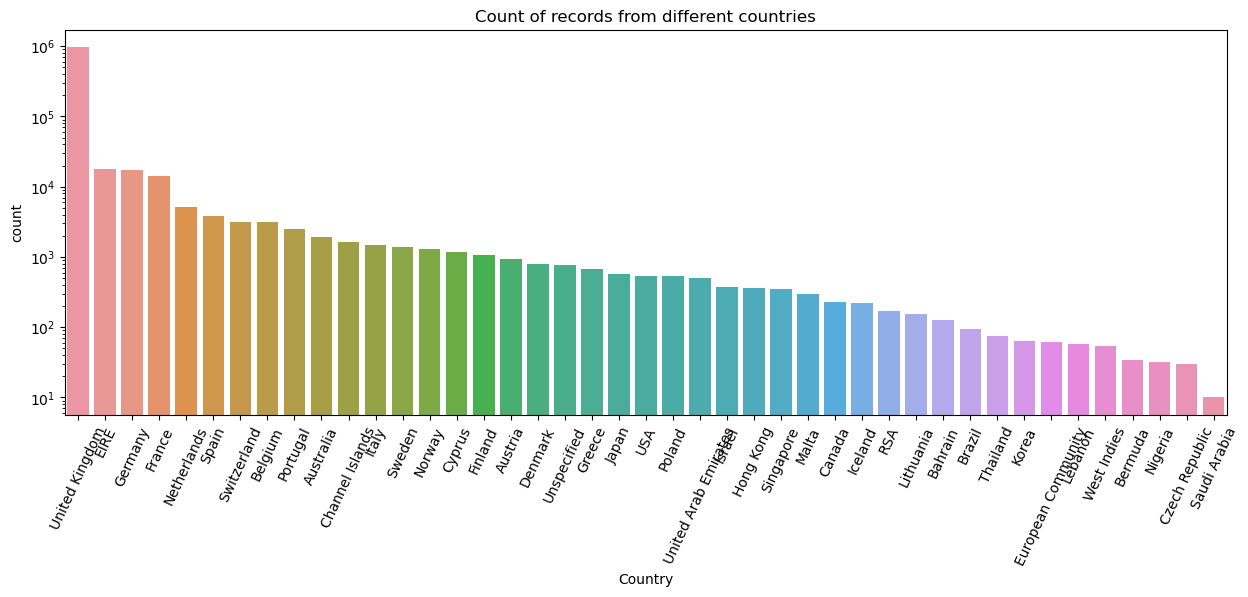

In [10]:
# counts of records in different countries
plt.figure(figsize = (15,5))
plt.xticks(rotation=65,size=10)
ax=sns.countplot(x='Country',data=df,order=df['Country'].value_counts().index)
ax.set_yscale("log")
plt.title('Count of records from different countries')
plt.show()

In [11]:
uk = df[df['Country']=='United Kingdom'].reset_index().drop(columns=['index']) 
# uk = uk.drop_duplicates()

uk = uk[uk['Quantity'] >= 0] # do not process cancellations/refund
uk = uk[uk['Price'] > 0] # do not process cancellations/refunds
uk['GMV'] = uk['Quantity']*uk['Price'] # total value = sales*price

uk['Month'] = uk['InvoiceDate'].dt.month
uk['Year'] = uk['InvoiceDate'].dt.year

In [12]:
uk.shape

(935556, 11)

In [13]:
unemployment['Month'] = unemployment['Month'].apply(lambda x: datetime.strptime(x, '%Y %b'))
unemployment['Year'] = unemployment['Month'].dt.year
unemployment['Month'] = unemployment['Month'].dt.month

In [14]:
earnings.rename(columns={ "Time": "Month" }, inplace = True)
earnings["Month"] = earnings['Month'].apply(lambda x: datetime.strptime(x, "%b-%y"))
earnings = earnings.rename(columns = {'Seasonally Adjusted Real AWE Total Pay (Index numbers 2015=100)': 'Average Wage'})
earnings = earnings[['Month', 'Average Wage']]
earnings['Year'] = earnings['Month'].dt.year
earnings['Month'] = earnings['Month'].dt.month

In [15]:
retail_spending = retail_spending.drop([0,1])[['Time Period','All Retailing excluding automotive fuel']]
retail_spending['Time Period'] = retail_spending['Time Period'].apply(lambda x: parser.parse(x))
retail_spending = retail_spending.rename(columns = {'All Retailing excluding automotive fuel': 'Retail Spending Monthly'})
retail_spending = retail_spending.reset_index()
retail_spending['Year'] = retail_spending['Time Period'].dt.year
retail_spending['Month'] = retail_spending['Time Period'].dt.month
retail_spending = retail_spending.drop(columns=['index'])
# retail_spending

In [19]:
df_uk = pd.merge(uk, unemployment, on=['Year', 'Month'], how='left')
df_uk = pd.merge(df_uk, earnings, on=['Year', 'Month'], how='left')
df_uk = pd.merge(df_uk, retail_spending, on=['Year', 'Month'], how='left')

df_uk['InvoiceDate'] = df_uk['InvoiceDate'].dt.date
df_uk = df_uk[['InvoiceDate', 'Unemployment Rate','Average Wage','GMV', 'Retail Spending Monthly']]
# df_uk

In [20]:
# Aggregate the data by day.
daily_gmv_uk = df_uk.groupby('InvoiceDate').agg(
    {
    'Unemployment Rate': 'mean',
    'Average Wage': 'mean',
    'Retail Spending Monthly': 'mean',
    'GMV': 'sum'
    }
)

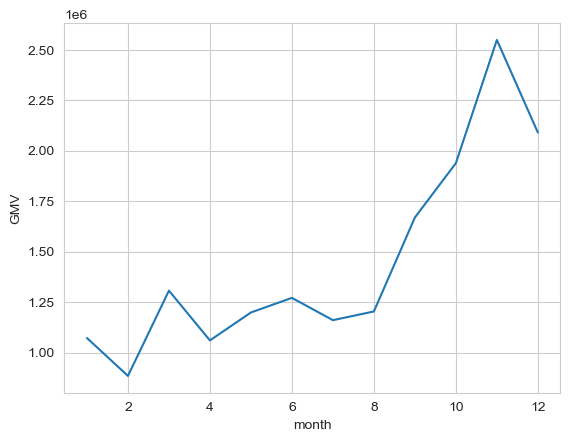

In [21]:
uk = daily_gmv_uk.reset_index().copy()
uk['InvoiceDate'] = pd.to_datetime(uk['InvoiceDate'])
uk["year"] = uk["InvoiceDate"].apply(lambda x: x.year)
uk["month"] = uk["InvoiceDate"].apply(lambda x: x.month)
uk["day"] = uk["InvoiceDate"].apply(lambda x: x.day)
uk["weekday"] = uk["InvoiceDate"].apply(lambda x: x.weekday())

# plot for GMV in each month in 2010
sns.set_style('whitegrid')
plot=pd.DataFrame(uk.groupby(['month'])['GMV'].sum()).reset_index()
ax=sns.lineplot(x="month",y="GMV",data=plot)

In [22]:
daily_gmv_uk.isna().sum()

Unemployment Rate          0
Average Wage               0
Retail Spending Monthly    0
GMV                        0
dtype: int64

In [23]:
daily_gmv_uk[['GMV']].describe()

,GMV
count,603.000000
mean,28881.322516
std,17537.827110
min,3457.110000
25%,18221.005000
50%,24444.160000
75%,35085.900000
max,196134.100000


Text(0, 0.5, 'GMV')

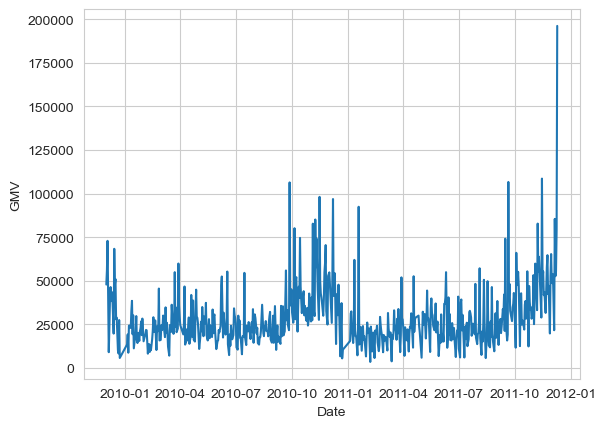

In [24]:
plt.plot(daily_gmv_uk.GMV)
plt.xlabel('Date')
plt.ylabel('GMV')

In [25]:
daily_gmv_uk = daily_gmv_uk.reset_index()
daily_gmv_uk['MA'] = daily_gmv_uk['GMV'].rolling(window=7).mean()
daily_gmv_uk.loc[602, 'GMV'] = daily_gmv_uk.loc[602, 'MA']

daily_gmv_uk.drop('MA', axis=1, inplace=True)

In [26]:
# daily_gmv_uk

In [27]:
# df_uk.to_csv('data/sales_uk.csv')
daily_gmv_uk.to_csv('data/daily_gmv_uk.csv')

In [28]:
correlation = daily_gmv_uk.corr()[['GMV']]
correlation = correlation[correlation['GMV']>0.1]
correlation

C:\Users\Ran Liao\AppData\Local\Temp\ipykernel_16328\3840758662.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = daily_gmv_uk.corr()[['GMV']]


,GMV
Unemployment Rate,0.253296
Retail Spending Monthly,0.291488
GMV,1.000000


<AxesSubplot: >

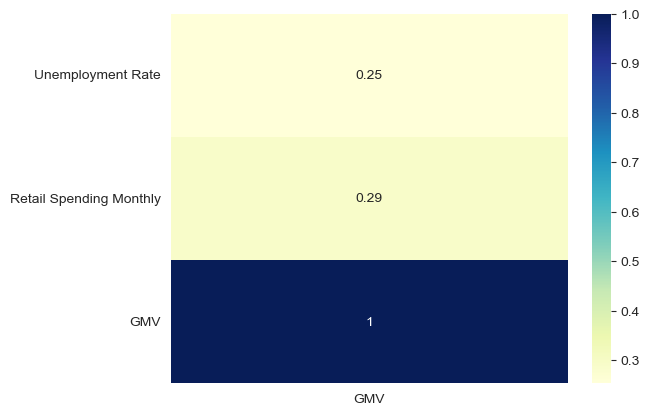

In [29]:
sns.heatmap(correlation[['GMV']], cmap="YlGnBu", annot=True)

In [30]:
attr = correlation.index.tolist() + ['InvoiceDate']
daily_gmv_uk = daily_gmv_uk[attr]

In [31]:
daily_gmv_uk[['GMV']].describe()

,GMV
count,603.000000
mean,28684.933584
std,16279.740158
min,3457.110000
25%,18221.005000
50%,24444.160000
75%,35085.900000
max,108579.940000


In [32]:
daily_gmv_uk['InvoiceDate'] = pd.to_datetime(daily_gmv_uk['InvoiceDate'])

In [33]:
daily_gmv_uk[['InvoiceDate']].describe()

C:\Users\Ran Liao\AppData\Local\Temp\ipykernel_16328\2317932221.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  daily_gmv_uk[['InvoiceDate']].describe()


,InvoiceDate
count,603
unique,603
top,2009-12-01 00:00:00
freq,1
first,2009-12-01 00:00:00
last,2011-12-09 00:00:00


# Pre-modeling

In [34]:
def plot_psd(x):
    freqs, psd = signal.welch(x)
    plt.figure(figsize=(10, 7))
    fig, ax = plt.subplots()
    ax.plot(freqs, psd)
    minor_locator = AutoMinorLocator(5)
    ax.xaxis.set_minor_locator(minor_locator)
    plt.grid(which='minor')
    plt.legend(['PSD'])
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    ax.grid(True, which='both')
    plt.tight_layout()
    fig.savefig('Stochastic_PSD.png')
    fig.show()

Text(0, 0.5, 'GMV')

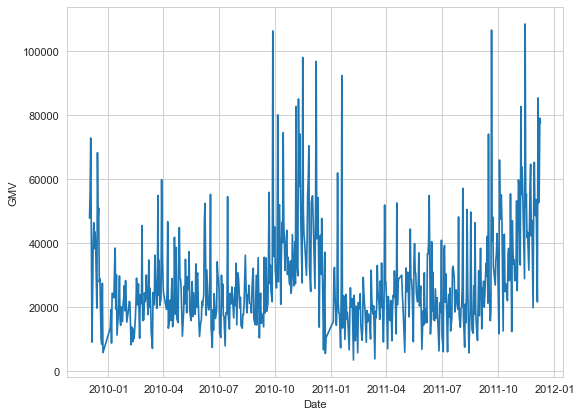

In [35]:
figure(figsize=(8, 6), dpi=80)
temp = daily_gmv_uk.copy()
temp.set_index(temp['InvoiceDate'],inplace=True)
plt.plot(temp.GMV)
plt.xlabel('Date')
plt.ylabel('GMV')

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

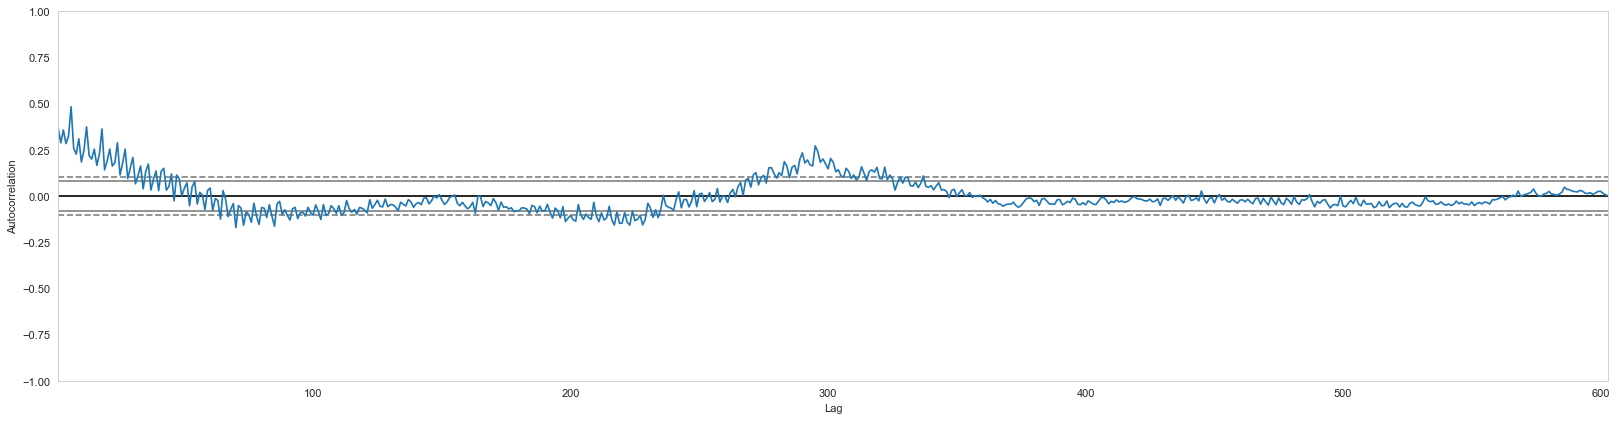

In [36]:
figure(figsize=(25, 6), dpi=80)
autocorrelation_plot(daily_gmv_uk.GMV)

<Figure size 2000x480 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

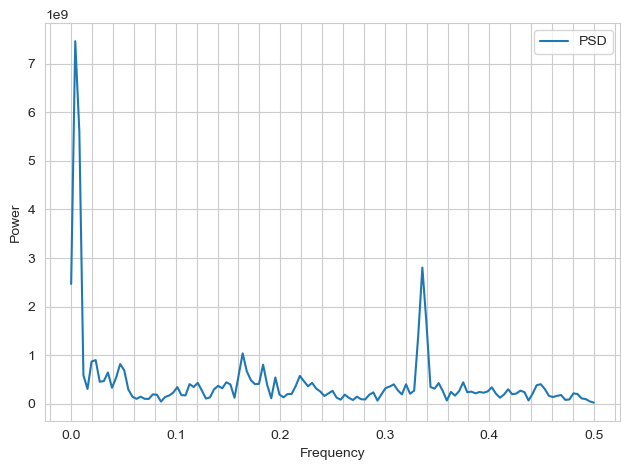

In [37]:
figure(figsize=(25, 6), dpi=80)
plot_psd(daily_gmv_uk.GMV)

In [38]:
freqs, psd = signal.welch(daily_gmv_uk.GMV)
spikes = list(pd.DataFrame(psd)[0].nlargest(3).index)

for idx in spikes:
    print("Power = ", psd[idx])
    print("Seasonality = ", 1/freqs[idx], "\n\n")

Power =  7465301163.049367
Seasonality =  256.0 


Power =  5611597708.818622
Seasonality =  128.0 


Power =  2802997343.6861877
Seasonality =  2.9767441860465116 




C:\Users\Ran Liao\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 2000x480 with 0 Axes>

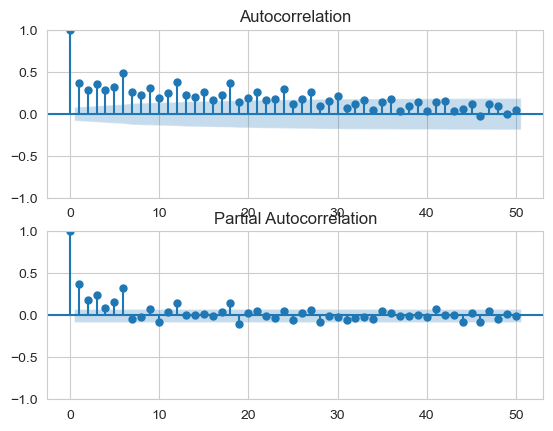

In [39]:
figure(figsize=(25, 6), dpi=80)
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(daily_gmv_uk.GMV, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(daily_gmv_uk.GMV, lags=50, ax=ax[1])
plt.show()

In [40]:
def ad_test(dataset):
    
    dftest = adfuller(dataset, autolag = 'AIC')
    
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
         print("\t",key, ": ", val)
         
         
ad_test(daily_gmv_uk.GMV)
# stationary

1. ADF :  -1.5092048787923096
2. P-Value :  0.5289530020698319
3. Num Of Lags :  18
4. Num Of Observations Used For ADF Regression: 584
5. Critical Values :
	 1% :  -3.4415970480373046
	 5% :  -2.866501759246704
	 10% :  -2.5694124827594296


# Modeling

In [41]:
# def MAPE(true, pred): 
#     import numpy as np
#     true, pred = np.array(true), np.array(pred)
#     return np.mean(np.abs((true - pred) / true)) * 100

In [42]:
# daily_gmv_uk['InvoiceDate']=pd.to_datetime(daily_gmv_uk['InvoiceDate'])
daily_gmv_uk.sort_index(inplace=True)
daily_gmv_uk

,Unemployment Rate,Retail Spending Monthly,GMV,InvoiceDate
0,7.7,35244288.0,47831.130000,2009-12-01
1,7.7,35244288.0,56055.190000,2009-12-02
2,7.7,35244288.0,72886.360000,2009-12-03
3,7.7,35244288.0,38116.950000,2009-12-04
4,7.7,35244288.0,9042.360000,2009-12-05
...,...,...,...,...
598,8.4,38280068.0,85452.990000,2011-12-05
599,8.4,38280068.0,52638.570000,2011-12-06
600,8.4,38280068.0,55338.420000,2011-12-07
601,8.4,38280068.0,79122.960000,2011-12-08


In [48]:
daily_gmv_uk['ds'] = daily_gmv_uk['InvoiceDate']
daily_gmv_uk['y'] = daily_gmv_uk['GMV']

In [86]:
# Split data into training and testing set
dev = daily_gmv_uk[:math.floor(0.85*len(daily_gmv_uk))]
test = daily_gmv_uk[math.floor(0.85*len(daily_gmv_uk)):]

print("Train: ", len(dev), "Test: ", len(test))

Train:  512 Test:  91


In [87]:
# from statsmodels.tsa.stattools import adfuller
# adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(dev)
# print(pvalue)

## Facebook Prophet

In [88]:
from prophet import Prophet
m = Prophet()
m.add_regressor('Unemployment Rate')
m.add_regressor('Retail Spending Monthly')
m.fit(dev)

21:40:46 - cmdstanpy - INFO - Chain [1] start processing
21:40:47 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
future = m.make_future_dataframe(periods=150)
future = future.merge(test[attr], left_on='ds', right_on='InvoiceDate')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Retail Spending Monthly,Retail Spending Monthly_lower,Retail Spending Monthly_upper,Unemployment Rate,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-08-25,14770.488370,12504.643019,45069.550525,14770.488370,14770.488370,-1981.322928,-1981.322928,-1981.322928,7570.392853,...,5589.069925,5589.069925,5589.069925,8547.147631,8547.147631,8547.147631,0.0,0.0,0.0,28906.705926
1,2011-08-26,14718.723167,5434.256682,36656.790140,14718.723167,14718.723167,-1981.322928,-1981.322928,-1981.322928,7570.392853,...,5589.069925,5589.069925,5589.069925,832.457984,832.457984,832.457984,0.0,0.0,0.0,21140.251077
2,2011-08-28,14615.192761,-4144.842475,28264.990426,14615.192761,14615.192761,-1981.322928,-1981.322928,-1981.322928,7570.392853,...,5589.069925,5589.069925,5589.069925,-8083.642818,-8083.642818,-8083.642818,0.0,0.0,0.0,12120.619869
3,2011-08-30,14511.662355,12947.919529,43029.471437,14511.662355,14511.662355,-1981.322928,-1981.322928,-1981.322928,7570.392853,...,5589.069925,5589.069925,5589.069925,8176.753410,8176.753410,8176.753410,0.0,0.0,0.0,28277.485691
4,2011-08-31,14459.897152,6534.890342,37915.725862,14459.344417,14461.055346,-1981.322928,-1981.322928,-1981.322928,7570.392853,...,5589.069925,5589.069925,5589.069925,2311.451061,2311.451061,2311.451061,0.0,0.0,0.0,22360.418139


In [90]:
mape = mean_absolute_percentage_error(future['GMV'], forecast['yhat'])
mape

0.36290319298483037

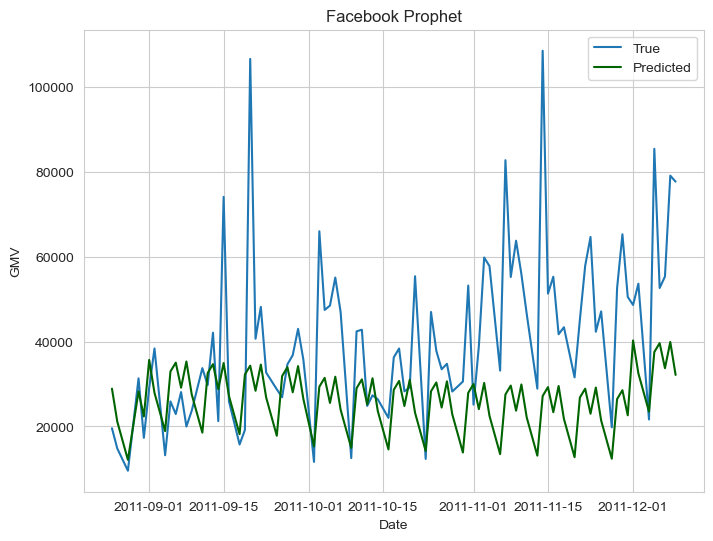

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(test.ds, test.y, label = 'True')
plt.plot(forecast.ds, forecast.yhat, color='darkgreen', label = 'Predicted')
plt.title('Facebook Prophet')
plt.xlabel('Date')
plt.ylabel('GMV')
plt.legend()
plt.show()

In [92]:
breakdowns = [0]

mapes = []

total_horizon = len(future['GMV'])
for i in range(4, 0, -1):
    breakdowns.append(math.floor((total_horizon) * 1/i))

for j in range(1, len(breakdowns)):
    st = breakdowns[j-1]
    en = breakdowns[j]
    mape_horizon = mean_absolute_percentage_error(future['GMV'][st:en], forecast[['yhat']][st:en])
    mapes.append(mape_horizon)

print(mapes)

[0.3377565478688542, 0.2239735009542255, 0.2967742982483083, 0.42065530493796394]


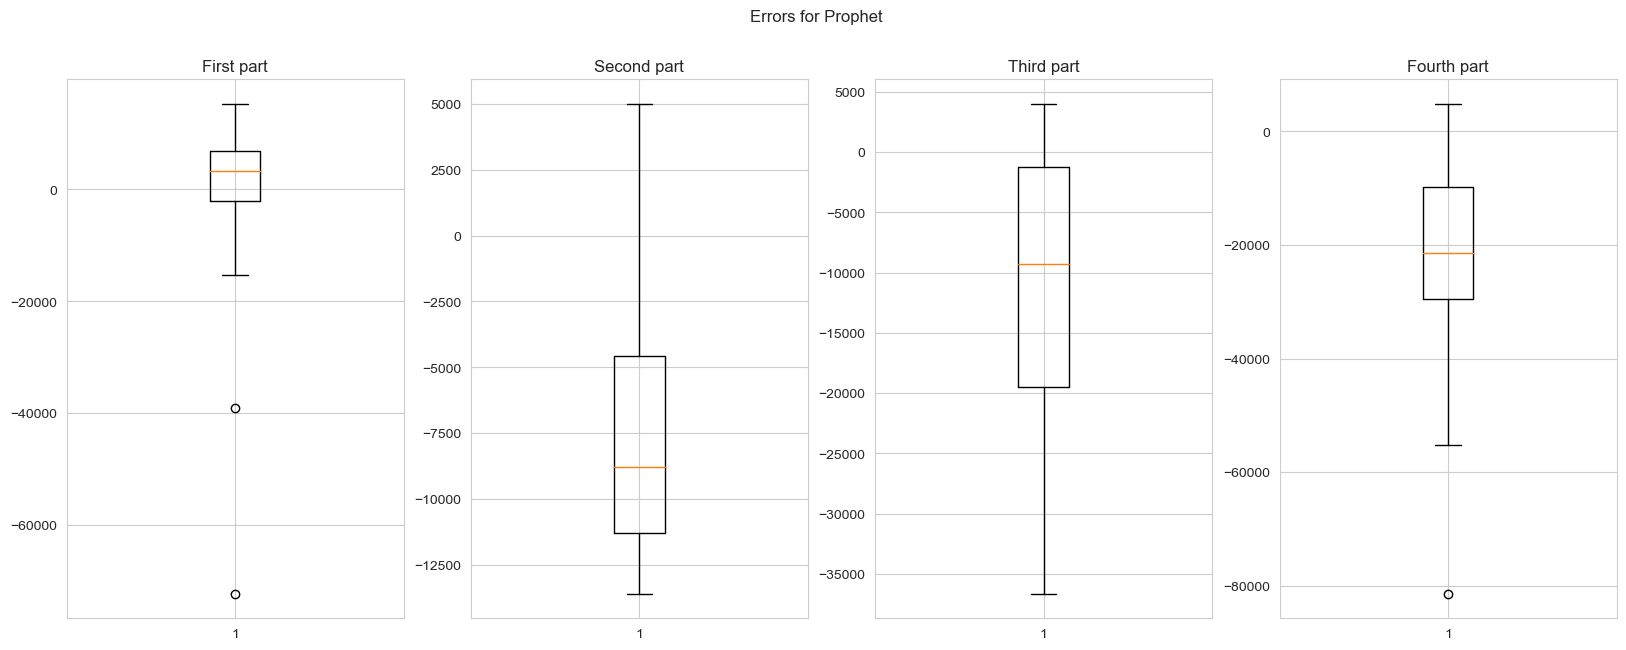

In [98]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7))
fig.suptitle('Errors for Prophet')
_ = ax1.boxplot(forecast['yhat'][:breakdowns[1]] - future['GMV'][:breakdowns[1]].values)
_ = ax2.boxplot(forecast['yhat'][breakdowns[1]:breakdowns[2]] - future['GMV'][breakdowns[1]:breakdowns[2]].values)
_ = ax3.boxplot(forecast['yhat'][breakdowns[2]:breakdowns[3]] - future['GMV'][breakdowns[2]:breakdowns[3]].values)
_ = ax4.boxplot(forecast['yhat'][breakdowns[3]:breakdowns[4]] - future['GMV'][breakdowns[3]:breakdowns[4]].values)
ax1.title.set_text('First part')
ax2.title.set_text('Second part')
ax3.title.set_text('Third part')
ax4.title.set_text('Fourth part')

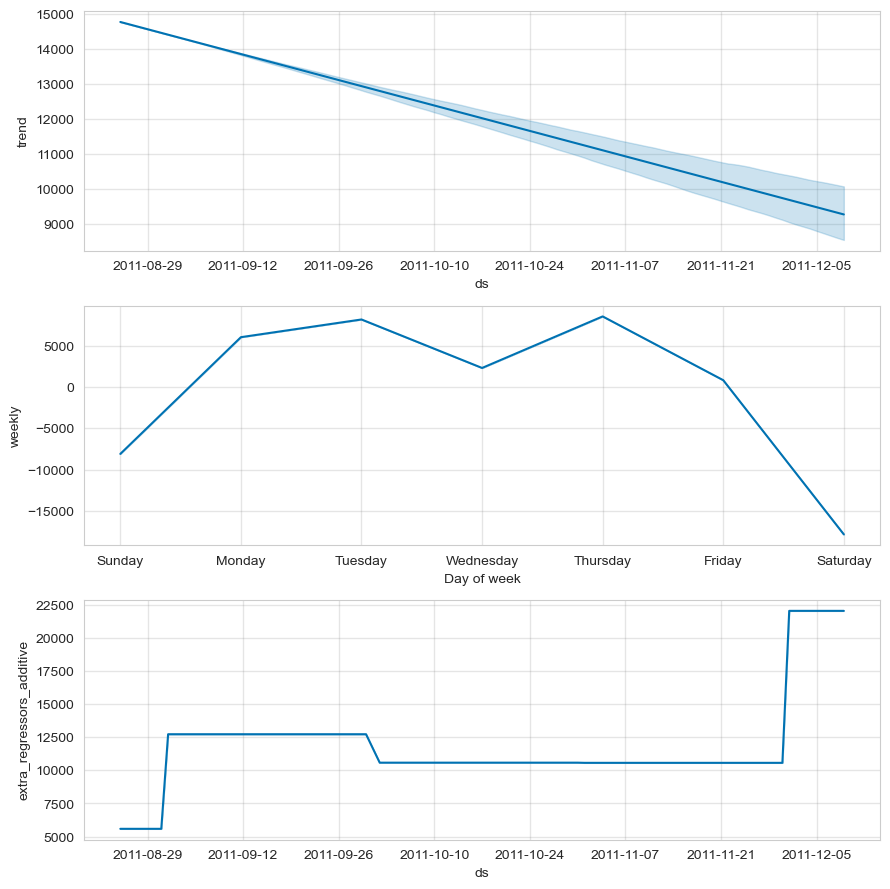

In [56]:
fig2 = m.plot_components(forecast)

In [57]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='100 days', period='20 days', horizon = '50 days')
df_cv.head()

  0%|          | 0/25 [00:00<?, ?it/s]

21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:08 - cmdstanpy - INFO - Chain [1] start processing
21:26:08 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:12 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-03-14,12695.451025,1026.050365,25475.259723,7063.720,2010-03-12
1,2010-03-15,22132.317286,9309.481494,34403.683157,24574.781,2010-03-12
2,2010-03-16,23810.630682,11423.952630,35965.346308,22768.530,2010-03-12
3,2010-03-17,19487.422964,7509.972304,31815.772239,20679.860,2010-03-12
4,2010-03-18,25333.702584,11545.004643,37323.987190,36252.970,2010-03-12


In [58]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,5 days,1.866654e+08,13662.556123,10067.194404,0.535969,0.313058,0.368298,0.752475
1,6 days,1.914360e+08,13836.038644,10204.219728,0.589795,0.317840,0.380394,0.775578
2,7 days,1.920996e+08,13860.001646,9749.405853,0.519692,0.293848,0.350323,0.813445
3,8 days,2.087743e+08,14449.024480,9963.475040,0.517420,0.291383,0.347156,0.807191
4,9 days,1.978909e+08,14067.368938,9632.298301,0.485052,0.275110,0.335534,0.846085


In [99]:
dev.set_index('InvoiceDate', inplace=True)
test.set_index('InvoiceDate', inplace=True)

In [100]:
X_dev = dev.drop(columns=['GMV','ds','y'])
y_dev = dev['GMV']


X_test = test.drop(columns=['GMV','ds','y'])
y_test = test['GMV']

In [101]:
X_dev.columns

Index(['Unemployment Rate', 'Retail Spending Monthly'], dtype='object')

In [102]:
import pmdarima as pmd
model = pmd.auto_arima(y_dev, start_p=0,d = 1,start_q=0, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_dev)

# Summary of the model
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11388.607, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11303.843, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11137.964, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11386.608, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11143.777, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11136.414, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11127.057, Time=0.87 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11127.145, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11128.799, Time=0.66 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11129.694, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11135.539, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11100.041, Time=1.67 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11088.122, Time=2.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11130.200, Time=1.69 sec
 ARIMA(4,1,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  512
Model:               SARIMAX(2, 1, 4)   Log Likelihood               -5534.633
Date:                Fri, 16 Dec 2022   AIC                          11083.266
Time:                        21:44:42   BIC                          11112.920
Sample:                             0   HQIC                         11094.891
                                - 512                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0139      0.014    -71.751      0.000      -1.042      -0.986
ar.L2         -0.9833      0.012    -83.176      0.000      -1.006      -0.960
ma.L1          0.2925      0.049      5.939      0.000       0.196       0.389
ma.L2          0.0860      0.037      2.354      0.019       0.014       0.158
ma.L3         -0.8205      0.032    -25.650      0.000      -0.883      -0.758
ma.L4         -0.1906      0.042     -4.488      0.000      -0.274      -0.107
sigma2       1.58e+08   9.62e-11   1.64e+18      0.000    1.58e+08    1.58e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               811.08
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             1.52
Prob(H) (two-sided):                  0.25   Kurtosis:                         8.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.53e+34. Standard errors may be unstable.
"""

In [103]:
pred = model.predict(n_periods=len(X_test))
mean_absolute_percentage_error(y_test, pred)

0.39566365784946345

In [104]:
breakdowns = [0]

mapes = []

total_horizon = len(y_test)
for i in range(4, 0, -1):
    breakdowns.append(math.floor((total_horizon) * 1/i))

for j in range(1, len(breakdowns)):
    st = breakdowns[j-1]
    en = breakdowns[j]
    mape_horizon = mean_absolute_percentage_error(y_test[st:en], pred[st:en])
    mapes.append(mape_horizon)

print(mapes)

[0.37945315096557447, 0.28449213362952436, 0.3657173432012541, 0.43251578969572885]


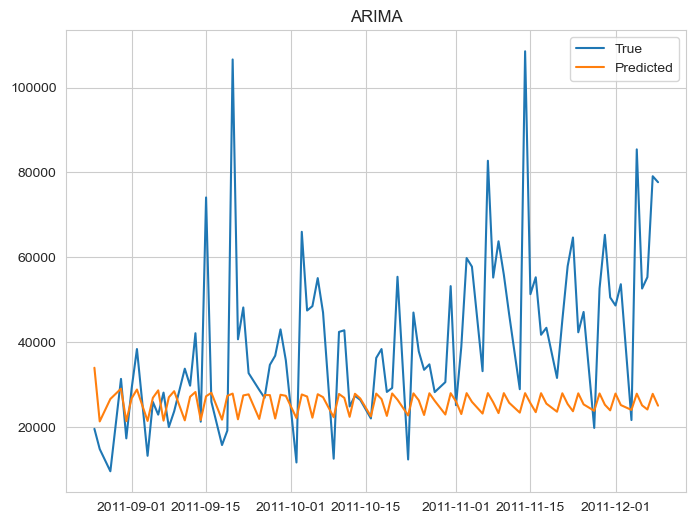

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(y_test.index, y_test.reset_index()['GMV'], label="True")
plt.plot(y_test.index, pred, label="Predicted")
plt.title('ARIMA')
plt.legend()

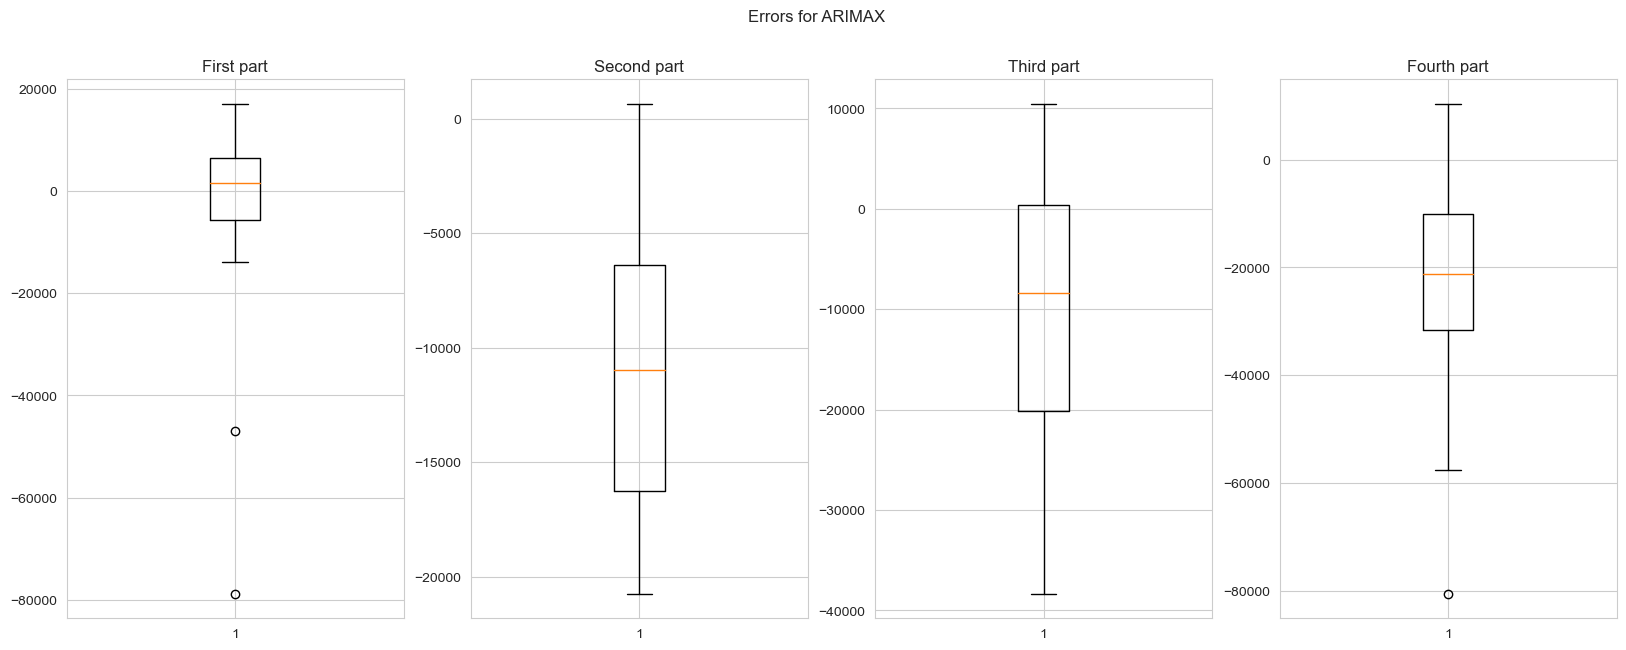

In [106]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7))
fig.suptitle('Errors for ARIMAX')
_ = ax1.boxplot(pred[:breakdowns[1]] - y_test[:breakdowns[1]].values)
_ = ax2.boxplot(pred[breakdowns[1]:breakdowns[2]] - y_test[breakdowns[1]:breakdowns[2]].values)
_ = ax3.boxplot(pred[breakdowns[2]:breakdowns[3]] - y_test[breakdowns[2]:breakdowns[3]].values)
_ = ax4.boxplot(pred[breakdowns[3]:breakdowns[4]] - y_test[breakdowns[3]:breakdowns[4]].values)
ax1.title.set_text('First part')
ax2.title.set_text('Second part')
ax3.title.set_text('Third part')
ax4.title.set_text('Fourth part')
# plt.ylim([-80000,20000])

In [66]:
import pmdarima as pmd

model = pmd.auto_arima(y=y_dev, X=X_dev, start_p=1, start_q=0,
                      test='adf',
                      max_p=15, max_q=6,
                      m=5,             
                      d=0,  
                      seasonal=True,
                      start_P=0,
                      start_Q=0,
                      max_P=10,
                      max_Q=10,
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=11198.299, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=11243.873, Time=0.54 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=11198.638, Time=0.83 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=11188.810, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=13924.895, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=11203.810, Time=0.74 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=11192.774, Time=1.12 sec
 ARIMA(0,0,1)(0,0,2)[5] intercept   : AIC=11193.664, Time=1.44 sec
 ARIMA(0,0,1)(1,0,0)[5] intercept   : AIC=11193.635, Time=0.86 sec
 ARIMA(0,0,1)(1,0,2)[5] intercept   : AIC=11192.206, Time=4.55 sec
 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=11214.836, Time=1.10 sec
 ARIMA(1,0,1)(0,0,1)[5] intercept   : AIC=11176.762, Time=1.66 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=11181.826, Time=2.29 sec
 ARIMA(1,0,1)(1,0,1)[5] intercept   : AIC=11181.811, Time=2.18 sec
 ARIMA(1,0,1)(0,0,2

C:\Users\Ran Liao\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Ran Liao\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\Ran Liao\miniconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(2,0,1)(0,0,3)[5] intercept   : AIC=11222.975, Time=2.03 sec
 ARIMA(1,0,2)(0,0,3)[5] intercept   : AIC=11190.015, Time=2.19 sec
 ARIMA(0,0,0)(0,0,3)[5] intercept   : AIC=11215.682, Time=2.63 sec
 ARIMA(0,0,2)(0,0,3)[5] intercept   : AIC=11198.637, Time=1.01 sec
 ARIMA(2,0,0)(0,0,3)[5] intercept   : AIC=11198.468, Time=1.84 sec
 ARIMA(2,0,2)(0,0,3)[5] intercept   : AIC=11228.181, Time=4.55 sec
 ARIMA(1,0,1)(0,0,3)[5]             : AIC=11186.989, Time=1.20 sec

Best model:  ARIMA(1,0,1)(0,0,3)[5] intercept
Total fit time: 62.580 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                  512
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2, 3], 5)   Log Likelihood               -5577.574
Date:                                   Fri, 16 Dec 2022   AIC                          11173.148
Time:                                           21:28:23   BIC                          11211.293
Sample:                                                0   HQIC                         11188.101
                                                   - 512                                         
Covariance Type:                                     opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                -107.8507    265.242     -0.407      0.684    -627.716     412.014
Unemployment Rate         752.9947    645.602      1.166      0.243    -512.363    2018.352
Retail Spending Monthly     0.0008      0.000      3.665      0.000       0.000       0.001
ar.L1                       0.7009      0.090      7.795      0.000       0.525       0.877
ma.L1                      -0.4888      0.113     -4.325      0.000      -0.710      -0.267
ma.S.L5                     0.1337      0.050      2.699      0.007       0.037       0.231
ma.S.L10                   -0.0538      0.049     -1.104      0.270      -0.149       0.042
ma.S.L15                    0.1009      0.045      2.258      0.024       0.013       0.188
sigma2                    1.76e+08      0.026   6.69e+09      0.000    1.76e+08    1.76e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1116.10
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             1.72
Prob(H) (two-sided):                  0.79   Kurtosis:                         9.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+24. Standard errors may be unstable.
"""

In [67]:
pred = model.predict(X=X_test, n_periods=len(X_test))
mean_absolute_percentage_error(y_test, pred)

0.40297306358772417

In [68]:
breakdowns = [0]

mapes = []

total_horizon = len(y_test)
for i in range(4, 0, -1):
    breakdowns.append(math.floor((total_horizon) * 1/i))

for j in range(1, len(breakdowns)):
    st = breakdowns[j-1]
    en = breakdowns[j]
    mape_horizon = mean_absolute_percentage_error(y_test[st:en], pred[st:en])
    mapes.append(mape_horizon)

print(mapes)

[0.46953745089182203, 0.19059795651502992, 0.4219977984890103, 0.40186900516103086]


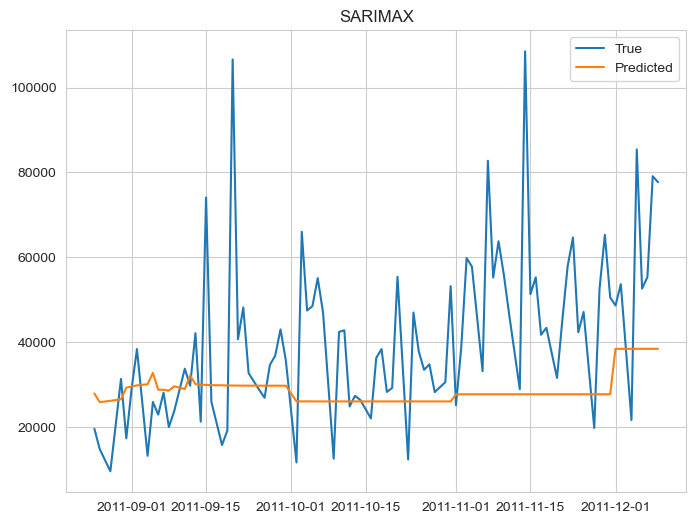

In [69]:
plt.figure(figsize=(8, 6))
plt.plot(y_test.index, y_test.reset_index()['GMV'], label="True")
plt.plot(y_test.index, pred, label="Predicted")
plt.title('SARIMAX')
plt.legend()

In [71]:
breakdowns

[0, 22, 30, 45, 91]

(-80000.0, 20000.0)

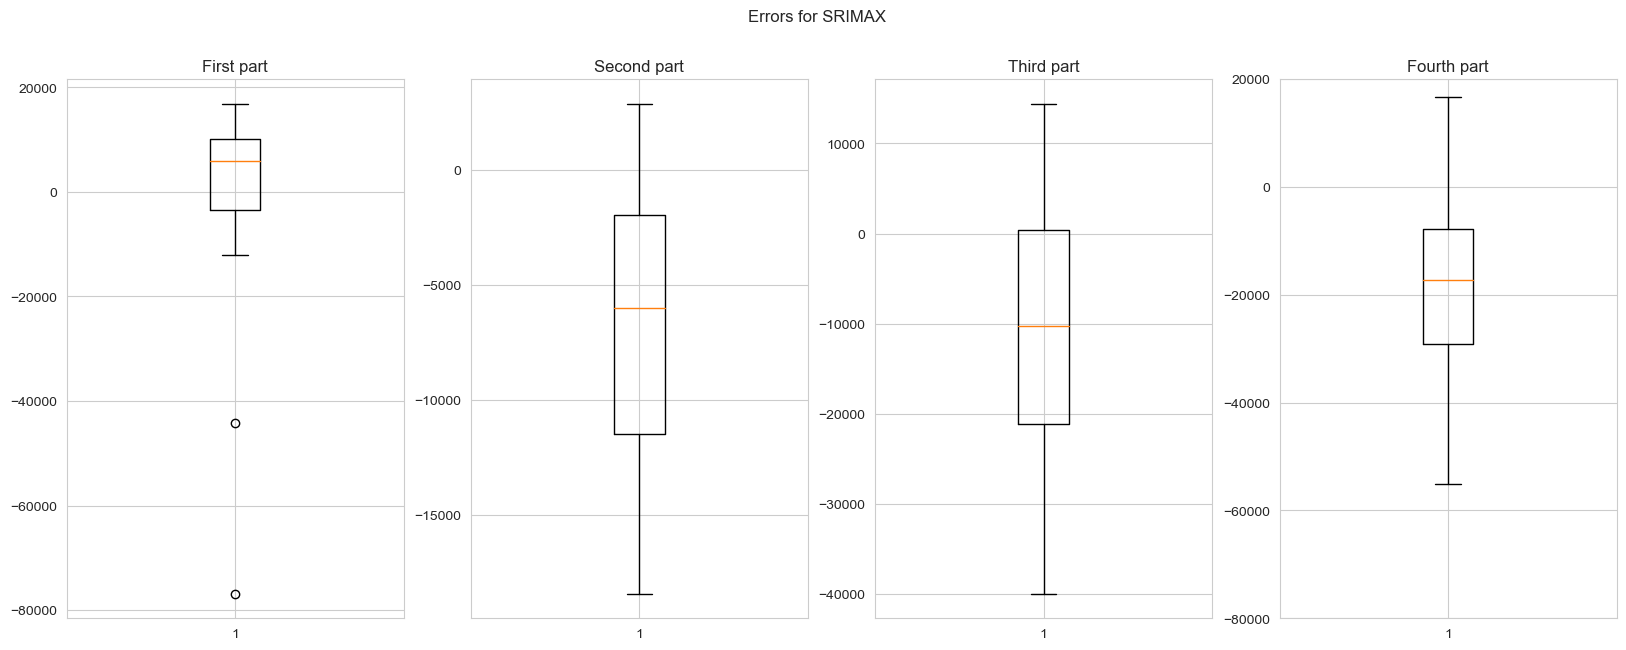

In [83]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7))
fig.suptitle('Errors for SRIMAX')
_ = ax1.boxplot(pred[:breakdowns[1]] - y_test[:breakdowns[1]].values)
_ = ax2.boxplot(pred[breakdowns[1]:breakdowns[2]] - y_test[breakdowns[1]:breakdowns[2]].values)
_ = ax3.boxplot(pred[breakdowns[2]:breakdowns[3]] - y_test[breakdowns[2]:breakdowns[3]].values)
_ = ax4.boxplot(pred[breakdowns[3]:breakdowns[4]] - y_test[breakdowns[3]:breakdowns[4]].values)
ax1.title.set_text('First part')
ax2.title.set_text('Second part')
ax3.title.set_text('Third part')
ax4.title.set_text('Fourth part')
plt.ylim([-80000,20000])

In [ ]:
# tss = TimeSeriesSplit(n_splits = 3)
# p_n = range(0, 15)
# q_n = range(0, 8)

# models = []
# mapes = []

# for train_index, val_index in tss.split(X_dev):
#   X_train, X_val = X_dev.iloc[train_index, :], X_dev.iloc[val_index,:]
#   y_train, y_val = y_dev.iloc[train_index], y_dev.iloc[val_index]

#   best_model = None
#   lowest_mape = 100

#   for p in p_n:
#     for q in q_n:
#       print("Fitting a ", p, 0, q, " model ")
#       model = ARIMA([p, 0, q])
#       model.fit(y_train, X_train)
#       preds, conf_int = model.predict(n_periods=y_val.shape[0], X=X_val,
#                                       return_conf_int=True)
#       mape = mean_absolute_percentage_error(y_val, preds)
#       if mape < lowest_mape:
#         lowest_mape = mape
#         best_model = model
#         print(f'MAPE is: {mape}')
#   models.append(best_model)
#   mapes.append(lowest_mape)

In [ ]:
# for m in mapes:
#   print(m)

# for m in models:
#   print(m)

In [ ]:
# model = ARIMA([8, 0, 5])
# model.fit(y_dev, X_dev)
# mean_absolute_percentage_error(y_test, model.predict(X=X_test, n_periods=len(X_test)))

In [ ]:
# model = ARIMA([12, 0, 7])
# model.fit(y_dev, X_dev)
# mean_absolute_percentage_error(y_test, model.predict(X=X_test, n_periods=len(X_test)))

In [ ]:
# model = ARIMA([3, 0, 3])
# model.fit(y_dev, X_dev)
# mean_absolute_percentage_error(y_test, model.predict(X=X_test, n_periods=len(X_test)))

# Monthly Forecasting (ignore)

In [ ]:
# monthly prediction
monthly_gmv_uk = df_uk.copy()

monthly_gmv_uk = monthly_gmv_uk.reset_index()
monthly_gmv_uk['InvoiceDate'] = pd.to_datetime(monthly_gmv_uk['InvoiceDate'])
monthly_gmv_uk['InvoiceYearMonth'] = monthly_gmv_uk['InvoiceDate'].dt.strftime('%Y-%m')

In [ ]:
monthly_gmv_uk = monthly_gmv_uk.groupby('InvoiceYearMonth').agg(
    {
    'Unemployment Rate': 'mean',
    'Average Wage': 'mean',
    'GMV': 'sum'
    }
)
monthly_gmv_uk.head()

In [ ]:
figure(figsize=(25, 6), dpi=80)
plt.plot(monthly_gmv_uk.GMV)

In [ ]:
# Split data into training and testing set
dev = monthly_gmv_uk[:math.floor(0.8*len(monthly_gmv_uk))]
test = monthly_gmv_uk[math.floor(0.8*len(monthly_gmv_uk)):]

print("Train: ", len(dev), "Test: ", len(test))
X_dev = dev.drop('GMV', axis=1)
y_dev = dev['GMV']

X_test = test.drop('GMV', axis=1)
y_test = test['GMV']

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(y_dev)
print(pvalue)

In [ ]:
import pmdarima as pmd
model = pmd.auto_arima(y_dev, exogenous=X_dev[['Price', 'Unemployment Rate', 'Average Wage']], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_dev, exogenous=X_dev[['Price', 'Unemployment Rate', 'Average Wage']])

In [ ]:
#Predict the future values
pred = model.predict(n_periods = len(X_test), exogenous=X_test[['Price', 'Unemployment Rate', 'Average Wage']])
MAPE(y_test, pred)

In [ ]:
plt.plot(y_test.reset_index()['GMV'], label="True")
plt.plot(pred, label="Predicted")
plt.legend()